In [1]:
import pandas as pd

from mlforecast import MLForecast
from statsforecast import StatsForecast
from sklearn.linear_model import LinearRegression
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from window_ops.ewm import ewm_mean

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.core import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM, LSTM
from neuralforecast.losses.pytorch import MQLoss
import matplotlib.pyplot as plt

from statsforecast.models import (
    # SeasonalNaive: A model that uses the previous season's data as the forecast
    SeasonalNaive
)

def create_date_format(
        df: pd.DataFrame, original_date_column: str
    ) -> pd.DataFrame:
        """
        Creates a pandas datetime object from a date string.
        Very specifiy to the output of the mdb notebook yrmo column.
        """
        df["yyyymm"] = df[original_date_column].apply(
            lambda x: str(x)[:4] + "-" + str(x)[4:] + "-01"
        )
        df["yyyymm"] = pd.to_datetime(df.yyyymm)
        return df

/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
df = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/impact_data/fra_eylea_20230215.csv')
df = create_date_format(df, 'yrmo')

df_nixtla = df[['cstmr_1_id', 'yyyymm', 'sales_unit']]# 'f2f_calls', 'remote_calls','ae_sent','evnt_invited', 'total_hcp_cnt']]
df_nixtla.rename(columns={'cstmr_1_id': 'unique_id', 'yyyymm': 'ds', 'sales_unit': 'y'}, inplace=True)

In [3]:
# lstm search spacce:

horizon=6

config_lstm = dict(
    input_size= tune.choice([horizon*1, horizon*2]),              # Length of input window
    encoder_hidden_size= tune.randint(12, 64),            # Hidden size of LSTM cells
    encoder_n_layers= tune.randint(2,5),                   # Number of layers in LSTM
    learning_rate= tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    scaler_type= tune.choice(['robust', 'standard']),                   # Scaler type
    max_steps= tune.randint(500, 1500),                    # Max number of training iterations
    batch_size= tune.choice([16, 32, 64, 128]),                        # Number of series in batch
    # random_seed= tune.randint(1, 20),                       # Random seed
    #hist_exog_list=['f2f_calls', 'remote_calls','ae_sent','evnt_invited','total_hcp_cnt'],
    #futr_exog_list =['f2f_calls', 'remote_calls','ae_sent','evnt_invited','total_hcp_cnt'],
    #stat_exog_list = ['total_hcp_cnt']
)

model = [AutoLSTM(h=horizon,
                  config=config_lstm, 
                  #futr_exog_list = ['gen_forecast', 'week_day'], # <- Future exogenous variables
                  #hist_exog_list = ['total_calls'], # <- Historical exogenous variables
                  #stat_exog_list = ['market_0', 'market_1'], # <- Static exogenous variables
                  loss = MQLoss(),
                  num_samples=2, # number of configurations explored --> ideally above 25,
                  search_alg=HyperOptSearch())
         ]

In [4]:
df_nixtla2 = df_nixtla[df_nixtla.ds<='2022-05-01'].copy()

nf = NeuralForecast(
     models=model,
     freq='MS')

val_size  = 18 # 3 x 6 months
test_size = 6 # 1 x 6 months

Y_hat_df = nf.cross_validation(df=df_nixtla2, 
                               val_size=val_size,
                               test_size=test_size, 
                               n_windows=None)

(_train_tune pid=11095) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 75.30it/s, v_num=0, train_loss_step=0.220, train_loss_epoch=0.245]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 51.31it/s, v_num=0, train_loss_step=0.182, train_loss_epoch=0.193, valid_loss=8.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 44.29it/s]
(_train_tune pid=11095) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 11.69it/s, v_num=0, train_loss_step=0.227, train_loss_epoch=0.197, valid_loss=6.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 61.46it/s]
(_train_tune pid=11095) 
Epoch 66:  67%|██████▋   | 4/6 [00:00<00:00, 68.84it/s, v_num=0, train_loss_step=0.180, train_loss_epoch=0.181, valid_loss=6.760]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 2/6 [00:00<00:00, 55.23it/s]
(_train_tune pid=11095) 
Epoch 83:  33%|███▎      |

2023-10-30 10:22:51,844	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 176:  67%|██████▋   | 4/6 [00:00<00:00, 73.12it/s, v_num=0, train_loss_step=0.183, train_loss_epoch=0.196, valid_loss=7.160]


(_train_tune pid=11095) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 90.28it/s, v_num=0, train_loss_step=0.317, train_loss_epoch=0.368] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 65.72it/s]
(_train_tune pid=11095) 
Validation DataLoader 0:  33%|███▎      | 8/24 [00:00<00:00, 61.66it/s]
(_train_tune pid=11095) 
Validation DataLoader 0:  62%|██████▎   | 15/24 [00:00<00:00, 61.72it/s]
(_train_tune pid=11095) 
Validation DataLoader 0:  88%|████████▊ | 21/24 [00:00<00:00, 61.51it/s]
(_train_tune pid=11095) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 89.65it/s, v_num=0, train_loss_step=0.319, train_loss_epoch=0.359, valid_loss=7.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██        | 5/24 [00:00<00:00, 61.06it/s]
(_train_tune pid=11095) 
Validation DataLoader 0:  46%|████▌     | 11/24 [00:00<00:00, 60.14it/s]
(_train_tune pid=11095) 
Validation DataLoader 0:  75%|███████▌  | 18/24 [00:00<00:00, 60.26it/s]
(_train

2023-10-30 10:23:04,539	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
Seed set to 1


Epoch 33: 100%|██████████| 24/24 [00:00<00:00, 37.17it/s, v_num=0, train_loss_step=0.420, train_loss_epoch=0.346, valid_loss=7.440]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [46]:
nf.models[0].results.get_best_result().config

{'input_size': 6,
 'encoder_hidden_size': 37,
 'encoder_n_layers': 3,
 'learning_rate': 0.00021751720394711215,
 'scaler_type': 'standard',
 'max_steps': 1060,
 'batch_size': 128,
 'h': 6,
 'loss': MQLoss(),
 'valid_loss': MQLoss()}

In [85]:
nf.fit(df=df_nixtla2)

(_train_tune pid=29399) Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 81.43it/s, v_num=0, train_loss_step=0.255, train_loss_epoch=0.279]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=29399) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 80.83it/s, v_num=0, train_loss_step=0.181, train_loss_epoch=0.190, valid_loss=7.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 79.84it/s]
(_train_tune pid=29399) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 81.27it/s, v_num=0, train_loss_step=0.199, train_loss_epoch=0.189, valid_loss=5.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 79.99it/s]
(_train_tune pid=29399) 
Epoch 66:  67%|██████▋   | 4/6 [00:00<00:00, 75.22it/s, v_num=0, train_loss_step=0.176, train_loss_epoch=0.194, valid_loss=5.660]
Validation: |          | 0/? 

2023-10-30 12:06:11,981	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 176:  17%|█▋        | 1/6 [00:00<00:00, 77.98it/s, v_num=0, train_loss_step=0.171, train_loss_epoch=0.189, valid_loss=5.330]


(_train_tune pid=29399) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 92.76it/s, v_num=0, train_loss_step=0.266, train_loss_epoch=0.372] 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=29399) 
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=29399) 
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 58.40it/s]
(_train_tune pid=29399) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 58.09it/s]
(_train_tune pid=29399) 
Validation DataLoader 0:  75%|███████▌  | 18/24 [00:00<00:00, 57.55it/s]
(_train_tune pid=29399) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 91.68it/s, v_num=0, train_loss_step=0.242, train_loss_epoch=0.348, valid_loss=4.660]
(_train_tune pid=29399) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=29399) 
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=29399) 
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 58.03it/s]
(_train_tune pid=29399) 
Validation DataLoader 

2023-10-30 12:06:24,704	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
Seed set to 1


Epoch 33: 100%|██████████| 24/24 [00:00<00:00, 32.58it/s, v_num=0, train_loss_step=0.222, train_loss_epoch=0.314, valid_loss=4.060]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [92]:
# save trained model:

nf.save(path='models', model_index=None, overwrite=True)

In [93]:
# load trained model:

fcst_pre_trained = NeuralForecast.load(path='models')

Seed set to 1


In [95]:
dfy = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/impact_data/it_eylea_20230215.csv')

dfy = create_date_format(dfy, 'yrmo')

df_nixtla_new = dfy[['cstmr_1_id', 'yyyymm', 'sales_unit']]# 'f2f_calls', 'remote_calls','ae_sent','evnt_invited', 'total_hcp_cnt']]
df_nixtla_new.rename(columns={'cstmr_1_id': 'unique_id', 'yyyymm': 'ds', 'sales_unit': 'y'}, inplace=True)
#df_nixtla_new2 = df_nixtla_new[(df_nixtla_new.ds<='2022-05-01')&(df_nixtla.ds>='2021-12-01')].copy()
df_nixtla_new2 = df_nixtla_new[['unique_id', 'ds','y']]

In [96]:
y_hat_new = fcst_pre_trained.predict(df=df_nixtla_new2).reset_index()

Predicting: |          | 0/? [00:00<?, ?it/s]

In [97]:
y_hat_new.head(7)

,unique_id,ds,LSTM-median,LSTM-lo-90,LSTM-lo-80,LSTM-hi-80,LSTM-hi-90
0,-,2022-12-01,-0.166111,-1.182621,-0.890671,1.073560,1.621067
1,-,2023-01-01,-0.085271,-1.330848,-0.978592,1.547002,2.330783
2,-,2023-02-01,0.022702,-1.389480,-1.025635,2.019802,2.908636
3,-,2023-03-01,0.036452,-1.400610,-1.038855,2.080162,3.001855
4,-,2023-04-01,-0.001745,-1.470996,-1.082841,2.114338,3.073843
5,-,2023-05-01,0.042402,-1.473865,-1.065061,2.243469,3.230591
6,0,2022-12-01,1118.307617,743.170654,853.638550,1601.221924,1817.370728


In [82]:
fcst_df = nf.predict(futr_df=df_nixtla)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [83]:
models = [SeasonalNaive]

sf = StatsForecast(
    models=models,  # selected models 
    freq='MS', # frequency denotes the granularity of the data. M for months in this case
    n_jobs=-1,
    #fallback_model = SeasonalNaive(season_length=12)
)

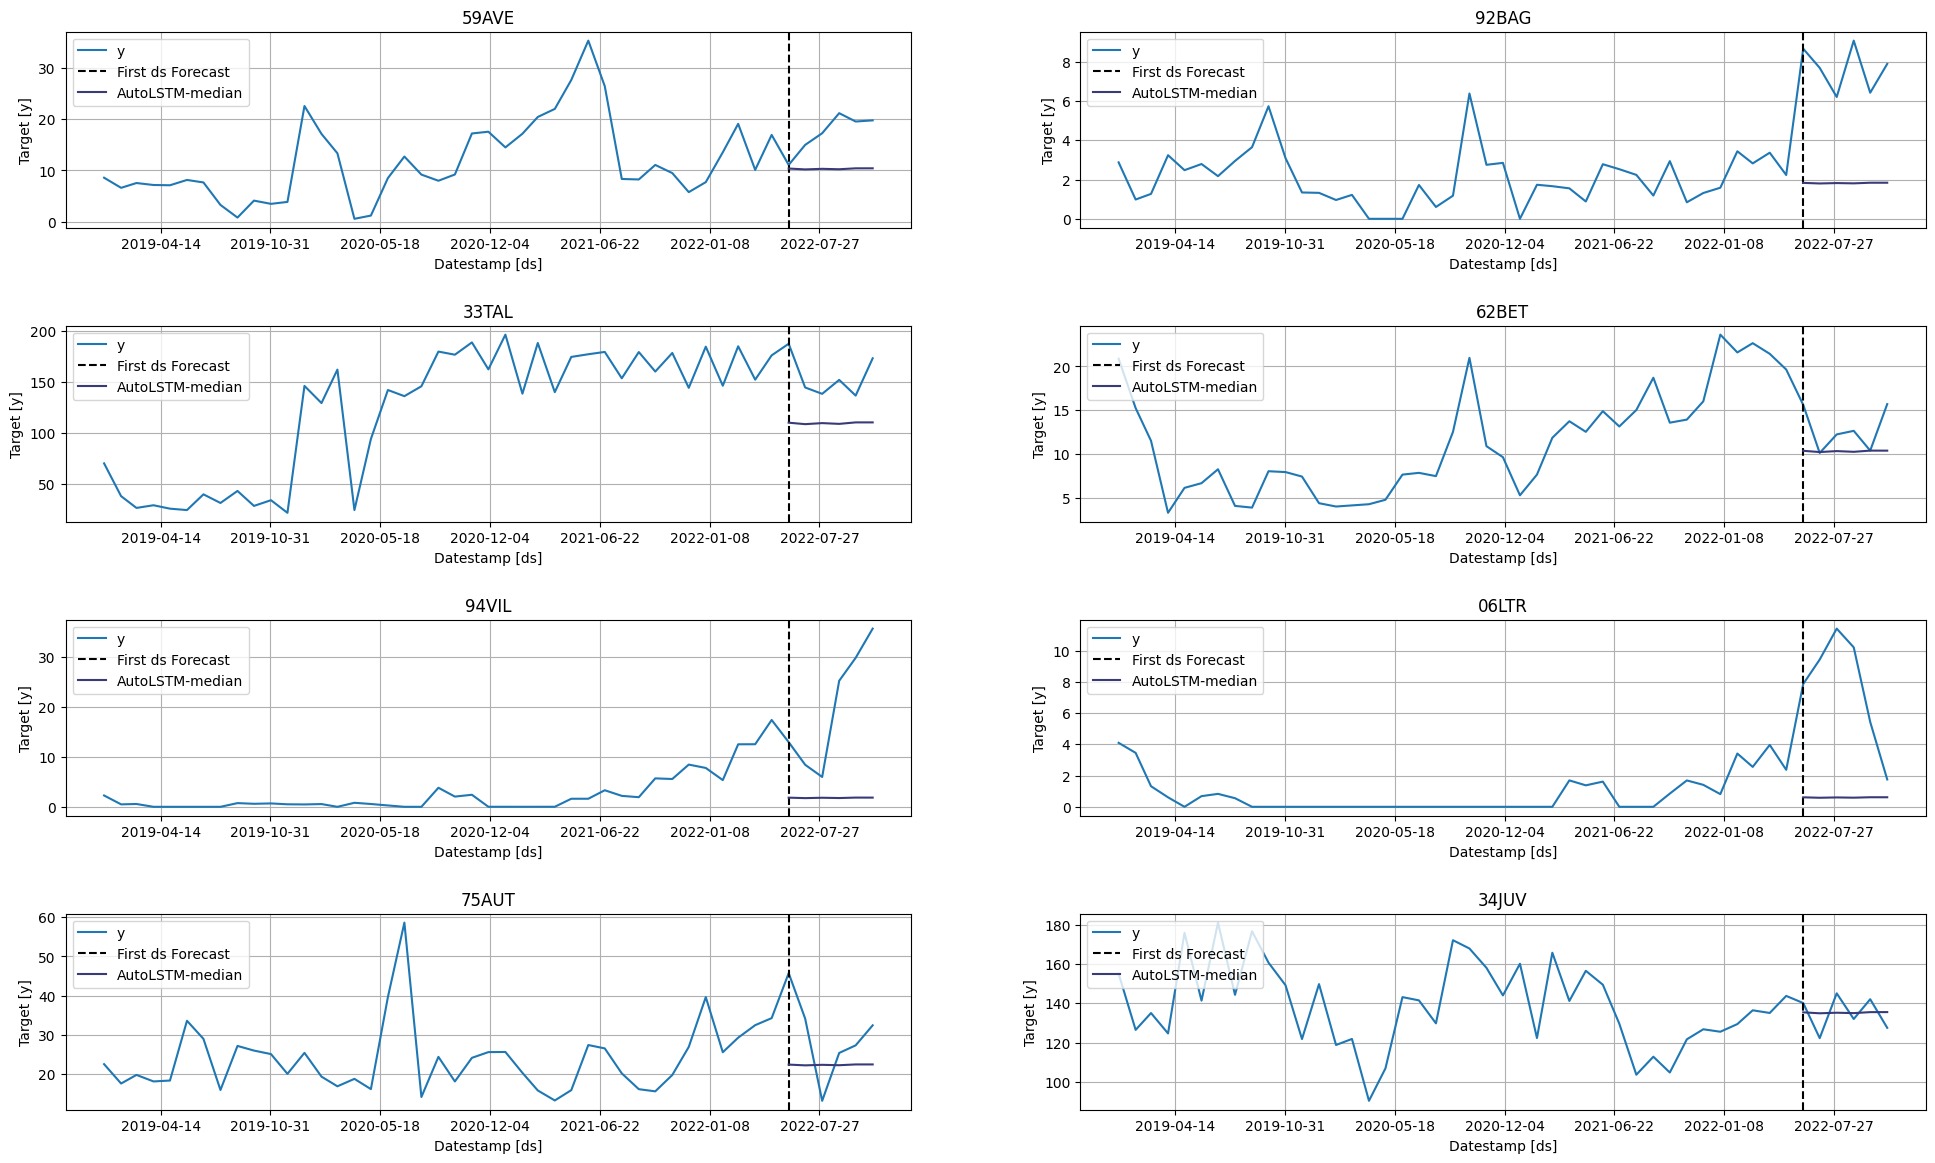

In [84]:
sf.plot(df_nixtla, fcst_df[['ds', 'AutoLSTM-median', 'AutoLSTM-lo-90', 'AutoLSTM-hi-90']], engine='matplotlib')